# Encoding experiment using the fast shared response model (FastSRM)

In this notebook we introduce some basic functionalities of FastSRM. We present an encoding experiment that shows how fmri data of train subjects can be used to predict fmri data of test subjects (after training).

More precisely, let us assume we have 2 groups of subjects (train, test) exposed to 2 similar but different naturalistic stimuli (session 1 and session 2) while we record their brain activity using an fMRI scanner. 

Our experiment follows the following steps:

- Align train subjects: We train an alignment model on session 1 using train subjects
- Align test subjects: Using data of test subjects during session 1 and the previously fitted model we add test subjects to the model
- Predict test subjects data from train subjects: We use the model to align train subjects during session 2. From the aligned data (shared response) we predict the data of test subjects during session 2.
- Measure performance: We report the R2 score between predicted and actual data.

# Real fMRI data

We'll download a publicly available fMRI dataset and run SRM on these data. This dataset comprises fMRI data for 20 subjects listening to the spoken story Pie Man by Jim O'Grady (archived on the Princeton DataSpace). Note that we use 20 subjects to minimize computational demands for this tutorial and recommend larger sample sizes for publication. The gzipped data archive file is ~1.5 GB in size, and may take a couple minutes to download and unzip. The functional data were acquired with 3 x 3 x 4 mm voxels and 1.5 s TRs. Data were preprocessed using fMRIPrep (Esteban et al., 2018), including spatial normalization to MNI space (the T1-weighted ICBM 2009c Nonlinear Asymmetric template). The data were then smoothed to 6 mm FWHM using AFNI's 3dBlurToFWHM (Cox, 1996). The following confound variables were regressed out using 3dTproject: six head motion parameters (and their first derivatives), framewise displacement, six prinicipal components from an anatomical mask of cerebrospinal fluid (CSF) and white matter, sine/cosine bases for high-pass filtering (cutoff: 0.00714 Hz; 140 s), as well as a linear and quadratic trends. The anatomical template and a brain mask (i.e., excluding skull) are supplied as well. These have been resampled to match resolution of the functional images.

In [1]:
import wget
from time import time
from glob import glob
from os.path import join
import nibabel
from nilearn.image import new_img_like
from nilearn.input_data import NiftiMasker, MultiNiftiMasker
import numpy as np
from joblib import Parallel, delayed
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tarfile
import os
from tqdm import tqdm

/home/hugo/Research/nilearn/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# Download data tarball from Princeton DataSpace (about 1 Gb to download) 
os.system("wget -q --show-progress --no-check-certificate -r 'https://drive.google.com/uc?export=download&confirm=5QPf&id=1IBA39ZZjeGS1u_DvZdiw1AZZQMS3K5q0' -O 'data.zip'")

0

In [3]:
os.system("unzip data.zip")

256

# Step 1: Mask and save the data
- We split our data into two sessions (in order to be able to perform our encoding experiment)
- We mask the data and save them into .npy file

### Note:
We use ``detrend=True`` and ``standardize=True`` in the ``NiftiMasker``. This is standard fMRI preprocessing and is needed for FastSRM to work.

In [21]:
t0 = time()
# the directory where our data are located
data_dir = 'Pieman2'
# Filenames for MRI data; gzipped NIfTI images (.nii.gz)

func_fns = sorted(glob(
    join(data_dir, "sub*", "func", "*task-intact1*.nii.gz")))

# The mask for our data
mask_fn = join(data_dir, "masks", "avg152T1_gray_3mm.nii.gz")

# What they call mask in their data is actually an atlas
# So we make it a proper mask
actual_mask = nibabel.load(mask_fn).get_data()
actual_mask = actual_mask > 0
actual_mask = new_img_like(mask_fn, actual_mask)

# Let us mask these data and separate them into two sessions
def separate_and_mask(func):
    # Load data
    N = nibabel.load(func).get_data()
    # Separate them into two sessions
    N_1 = N[:, :, :, :250]
    N_2 = N[:, :, :, 250:]
    I_1 = new_img_like(func, N_1)
    I_2 = new_img_like(func, N_2)
    # Mask data
    masker = NiftiMasker(
        mask_img=actual_mask, 
        detrend=True,
        standardize=True,
        smoothing_fwhm=6
    ).fit()
    # Transpose the data to fit with SRM conventions
    X_1 = masker.transform(I_1).T
    X_2 = masker.transform(I_2).T
    # Save data
    np.save(func[:-7] + "_session_1", X_1)
    np.save(func[:-7] + "_session_2", X_2)
    return [func[:-7] + "_session_1.npy", func[:-7] + "_session_2.npy"]

# I have 4 cores in my computer, it you have more increase n_jobs
files = Parallel(n_jobs=4, verbose=10)(
    delayed(separate_and_mask)(
        func
    ) for func in func_fns)
print("Done in %.2f seconds" % (time() - t0))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   30.7s
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed:   38.7s remaining:   14.9s
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed:   39.5s remaining:    7.9s


Done in 46.89 seconds


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:   46.5s finished


# Step 2: Fit of the model and predict data of left-out subjects
- Load data
- Train model on first session using train subjects 
- Compute shared response on second session using train subjects
- Compute alignment for test subjects using session 1
- Predict data of test subjects during session 2 using the trained model

### Note about input images
##### ProbSRM/DetSRM possible input
- imgs is a list of arrays where element i of the array is a numpy array of shape [n_voxels, n_timeframes] that contains the data of subject i

##### FastSRM possible input
- imgs is a list of arrays where element i of the array is a numpy array of shape [n_voxels, n_timeframes] that contains the data of subject i

- imgs is a list of list of arrays where element i, j of the array is a numpy array of shape [n_voxels, n_timeframes] that contains the data of subject i collected during session j.

- imgs is an np array imgs, imgs[i, j] is a path to the data of subject i collected during session j. Data are loaded with numpy.load and expected shape is [n_voxels, n_timeframes] n_timeframes and n_voxels are assumed to be the same across subjects n_timeframes can vary across sessions. Each voxel’s timecourse is assumed to have mean 0 and variance 1

=> So FastSRM can be used with very large dataset (even those where data cannot be hold in memory)

In [37]:
files = np.array(files)
n_subjects, n_sessions = files.shape
files.shape

(98508, 250)

In [58]:
from fastsrm.identifiable_srm import IdentifiableFastSRM

fastsrm = IdentifiableFastSRM(
    n_jobs=4,
    n_iter=1,
    tol=1e-7,
    n_iter_reduced=10000,
    identifiability="decorr",
    verbose=False,
    temp_dir=data_dir, # We will use the disk as if we had a small memory
    aggregate="mean" # transform will return the mean of subject specific shared response
)

In [59]:
from sklearn.model_selection import KFold

print("Running reconstruction experiment")
t0 = time()
# List in which we record for each subject the test R2 scores per voxels
r2_subjects = []
# We divide all subjects into train  subjects and test subjects
for subjects_train, subjects_test in tqdm(KFold(n_splits=5,
                                    shuffle=True
                                   ).split(np.arange(n_subjects))):

    # First let us train the model on train subjects during session 1
    # # For this we will use an input format that is supported by both FastSRM and SRM: a list of arrays
    train_subjects_session_1 = [np.load(files[s, 0]) for s in subjects_train]
    train_subjects_session_2 = [np.load(files[s, 1]) for s in subjects_train]
    test_subjects_session_1 = [np.load(files[s, 0]) for s in subjects_test]
    test_subjects_session_2 = [np.load(files[s, 1]) for s in subjects_test]
    
    n_subjects_train = len(subjects_train)
    n_subjects_test = len(subjects_test)

    # # Let us fit the model on the first session
    fastsrm.fit(train_subjects_session_1)
    # Compute a shared response from train subjects on session 1
    shared_session_1 = fastsrm.transform(train_subjects_session_1)
    # Compute a shared response from train subjects on session 2
    shared_session_2 = fastsrm.transform(train_subjects_session_2)
    # Add new test subjects to the model
    fastsrm.add_subjects(test_subjects_session_1, shared_session_1)

    # Then we try to reconstruct the data of test subjects during
    # session 2
    reconstructed_data_test_subjects_session_2 = fastsrm.inverse_transform(
            shared_session_2,
            subjects_indexes=np.arange(
                n_subjects_train, n_subjects_train + n_subjects_test))

    # This is the true data we are trying to reconstruct ()
    real_data_test_subjects_session_2 = np.array([np.load(file) for file in files[subjects_test,1]])

    for i in range(n_subjects_test):
        diff = reconstructed_data_test_subjects_session_2[i] - real_data_test_subjects_session_2[i]
        r2 = 1 - diff.var(axis=1)
        r2_subjects.append(r2)

r2_score = np.mean(r2_subjects, axis=0)
print("Done in %.2f" % (time() - t0))




0it [00:00, ?it/s]

Running reconstruction experiment





1it [00:13, 13.78s/it]


2it [00:27, 13.70s/it]


3it [00:39, 13.34s/it]


4it [00:53, 13.38s/it]


5it [01:20, 16.18s/it]

Done in 80.90


# Step 5: Plot results

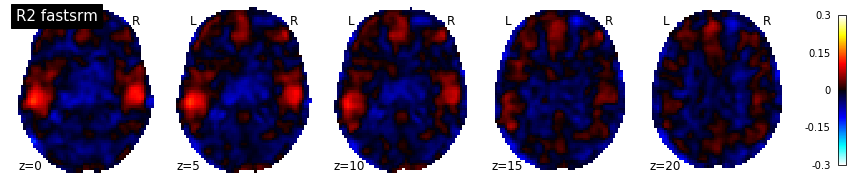

In [61]:
masker = NiftiMasker(
        mask_img=actual_mask).fit()

for name in ["fastsrm"]:
    plot_stat_map(
        masker.inverse_transform(r2_score),
        display_mode="z",
        cut_coords=[0, 5, 10, 15, 20],
        vmax=0.3,
        title="R2 %s" % name
    )